# Recurrent DQN

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

# Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
# import numpy as np
# state = env.reset()
# for _ in range(10):
#     # env.render()
#     action = env.action_space.sample()
#     next_state, reward, done, info = env.step(action) # take a random action
#     #print('state, action, next_state, reward, done, info:', state, action, next_state, reward, done, info)
#     state = next_state
#     if done:
#         state = env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [4]:
def model_input(state_size, hidden_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # RNN
    cell = tf.nn.rnn_cell.GRUCell(hidden_size)
    #cell = tf.nn.rnn_cell.LSTMCell(hidden_size)
    cells = tf.nn.rnn_cell.MultiRNNCell([cell], state_is_tuple=False)
    initial_state = cells.zero_state(batch_size, tf.float32)
    is_training = tf.placeholder(dtype=tf.bool, shape=[], name='is_training')
    print('initial_state, cells, cell', initial_state, cells, cell)
    return states, actions, targetQs, cells, initial_state, is_training

In [5]:
def init_xavier(random_seed=1, dtype=tf.float32, uniform=False):
    xavier = tf.contrib.layers.xavier_initializer(
        dtype=dtype,
        seed=tf.set_random_seed(random_seed), 
        uniform=uniform) # False: normal
    return xavier

In [6]:
def mlp(inputs, units, trainable=True):
    outputs = tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(), # Xavier with normal init
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)
    return outputs

In [7]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None
# )
def nl(inputs, alpha=0.2):
    outputs = tf.maximum(alpha * inputs, inputs)
    return outputs

In [8]:
def bn(inputs, training=True):
    outputs = tf.layers.batch_normalization(
        inputs=inputs,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training,
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)
    return outputs

In [9]:
# Actor-Critic or Discriminator/classifier
def D(states, action_size, initial_state, cells, hidden_size, reuse=False, is_training=True): 
    with tf.variable_scope('D', reuse=reuse):
        # First fully connected layer
        inputs = mlp(inputs=states, units=hidden_size)
        inputs = bn(inputs=inputs, training=is_training)
        inputs = nl(inputs)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size and
        # static means can NOT adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, hidden_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cells, inputs=inputs_rnn, 
                                                     initial_state=initial_state)
        #outputs_rnn = tf.layers.batch_normalization(inputs=outputs_rnn, training=is_training)
        #final_state = tf.layers.batch_normalization(inputs=final_state, training=is_training)
        print(outputs_rnn.shape, final_state)
        outputs = tf.reshape(outputs_rnn, [-1, hidden_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        actions_logits = mlp(inputs=outputs, units=action_size)
        print(actions_logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return actions_logits, final_state

In [10]:
def model_loss(action_size, hidden_size, states, cells, initial_state, actions, targetQs, is_training):
    
    actions_logits, final_state = D(states=states, cells=cells, initial_state=initial_state, 
                                    hidden_size=hidden_size, action_size=action_size, is_training=is_training)
    
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    
    return actions_logits, final_state, loss

In [11]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('D')]

    # # Optimize MLP/CNN/RNN without clipping grads
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=d_vars)

        # Optimize RNN
        #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
        #grads = tf.gradients(loss, g_vars)
        #opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))
    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        (self.states, self.actions, self.targetQs, cells, self.initial_state, \
         self.is_training) = model_input(
                state_size=state_size, hidden_size=hidden_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, cells=cells, initial_state=self.initial_state, 
            is_training=self.is_training)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
# Network parameters
action_size = 2
state_size = 4
hidden_size = 128               # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
# memory_size = 128            # memory capacity - 1000 DQN
batch_size = 128             # experience mini-batch size - 20 DQN
gamma = 0.99                 # future reward discount

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# # Init the memory
# memory = Memory(max_size=batch_size)

initial_state, cells, cell Tensor("MultiRNNCellZeroState/MultiRNNCellZeroState/zeros:0", shape=(1, 128), dtype=float32) <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7fa7401e0ef0> <tensorflow.python.ops.rnn_cell_impl.GRUCell object at 0x7fa7401e0dd8>
(?, 4) (?, 128)
(1, ?, 128) Tensor("MultiRNNCellZeroState/MultiRNNCellZeroState/zeros:0", shape=(1, 128), dtype=float32)
(1, ?, 128) Tensor("D/rnn/while/Exit_3:0", shape=(1, 128), dtype=float32)
(?, 128)
(?, 2)


In [15]:
model.initial_state[0], model.final_state, model.initial_state, model.is_training, model.actions, \
model.actions_logits, model.loss, model.opt, model.states, model.targetQs

(<tf.Tensor 'strided_slice:0' shape=(128,) dtype=float32>,
 <tf.Tensor 'D/rnn/while/Exit_3:0' shape=(1, 128) dtype=float32>,
 <tf.Tensor 'MultiRNNCellZeroState/MultiRNNCellZeroState/zeros:0' shape=(1, 128) dtype=float32>,
 <tf.Tensor 'is_training:0' shape=() dtype=bool>,
 <tf.Tensor 'actions:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'D/dense_1/BiasAdd:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'Mean:0' shape=() dtype=float32>,
 <tf.Operation 'Adam' type=NoOp>,
 <tf.Tensor 'states:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'targetQs:0' shape=(?,) dtype=float32>)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
def learn(batch, sess, gamma=0.99):
    states = np.array([each[0] for each in batch if each is not None])
    actions = np.array([each[1] for each in batch if each is not None])
    next_states = np.array([each[2] for each in batch if each is not None])
    rewards = np.array([each[3] for each in batch if each is not None])
    dones = np.array([each[4] for each in batch if each is not None])
    initial_states = np.array([each[5] for each in batch if each is not None])
    #print('initial_states.shape', initial_states.shape)
    #print('initial_states[0].shape', initial_states[0].shape)

    next_actions_logits = sess.run(model.actions_logits, 
                                   feed_dict = {model.states: next_states,
                                                model.is_training: False,
                                                model.initial_state: initial_states[1]})

    nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
    targetQs = rewards + (gamma * nextQs)

    loss, _ = sess.run([model.loss, model.opt], 
                       feed_dict = {model.states: states, 
                                    model.actions: actions,
                                    model.targetQs: targetQs,
                                    model.is_training: True,
                                    model.initial_state: initial_states[0]})    
    return loss

In [17]:
def act(sess, state, initial_state, is_training):
    action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                          feed_dict = {model.states: state.reshape([1, -1]), 
                                                       model.is_training: False,
                                                       model.initial_state: initial_state})
    action = np.argmax(action_logits)
    return action, final_state

In [ ]:
import numpy as np
from collections import deque

saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    batch = deque(maxlen=batch_size)
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        initial_state = sess.run(model.initial_state)

        # Training steps/batches
        while True:
            action, final_state =  act(sess=sess, state=state, initial_state=initial_state, is_training=False)
            
            next_state, reward, done, _ = env.step(action)
            
            batch.append([state, action, next_state, reward, float(done), initial_state])
            
            total_reward += reward
            state = next_state
            initial_state = final_state

            # Training
            #print('len(batch), batch.maxlen', len(batch), batch.maxlen)
            if len(batch) >= batch_size:
                loss = learn(batch=batch, gamma=gamma, sess=sess)
            else: loss = 0
                
            loss_batch.append(loss)
                
            if done is True:
                break
            
        # #print('len(batch), batch.maxlen', len(batch), batch.maxlen)
        # if len(batch) > 5:
        #     if len(batch) < batch_size:
        #         for _ in range(20):
        #             loss = learn(batch=batch, gamma=gamma, sess=sess)
        #             loss_batch.append(loss)

                
        # Outputing: priting out/Potting
        episode_reward.append(total_reward)
        
        print('Episode:{}'.format(ep),
              'meanR:{:.2f}'.format(np.mean(episode_reward)),
              'R:{:.2f}'.format(total_reward),
              'loss:{:.2f}'.format(np.mean(loss_batch)))
        
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:12.00 R:12.00 loss:0.00
Episode:1 meanR:11.50 R:11.00 loss:0.00
Episode:2 meanR:11.00 R:10.00 loss:0.00
Episode:3 meanR:10.75 R:10.00 loss:0.00
Episode:4 meanR:10.60 R:10.00 loss:0.00
Episode:5 meanR:10.83 R:12.00 loss:0.00
Episode:6 meanR:11.00 R:12.00 loss:0.00
Episode:7 meanR:11.00 R:11.00 loss:0.00
Episode:8 meanR:11.00 R:11.00 loss:0.00
Episode:9 meanR:10.80 R:9.00 loss:0.00
Episode:10 meanR:10.64 R:9.00 loss:0.00
Episode:11 meanR:10.67 R:11.00 loss:0.14
Episode:12 meanR:10.54 R:9.00 loss:1.16
Episode:13 meanR:10.36 R:8.00 loss:0.46
Episode:14 meanR:10.27 R:9.00 loss:0.26
Episode:15 meanR:10.19 R:9.00 loss:0.24
Episode:16 meanR:10.18 R:10.00 loss:0.14
Episode:17 meanR:10.11 R:9.00 loss:0.08
Episode:18 meanR:10.05 R:9.00 loss:0.07
Episode:19 meanR:10.00 R:9.00 loss:0.06
Episode:20 meanR:9.95 R:9.00 loss:0.05
Episode:21 meanR:9.95 R:10.00 loss:0.04
Episode:22 meanR:9.91 R:9.00 loss:0.05
Episode:23 meanR:9.83 R:8.00 loss:0.05
Episode:24 meanR:9.84 R:10.00 loss:0.04
Ep

Episode:203 meanR:15.10 R:10.00 loss:17.59
Episode:204 meanR:15.10 R:10.00 loss:17.84
Episode:205 meanR:15.12 R:12.00 loss:17.80
Episode:206 meanR:15.15 R:13.00 loss:17.81
Episode:207 meanR:15.18 R:12.00 loss:17.37
Episode:208 meanR:15.20 R:11.00 loss:17.44
Episode:209 meanR:15.24 R:12.00 loss:17.29
Episode:210 meanR:15.28 R:13.00 loss:16.84
Episode:211 meanR:15.29 R:11.00 loss:16.63
Episode:212 meanR:15.30 R:11.00 loss:16.25
Episode:213 meanR:15.32 R:12.00 loss:16.11
Episode:214 meanR:15.35 R:12.00 loss:15.44
Episode:215 meanR:15.39 R:13.00 loss:14.67
Episode:216 meanR:15.42 R:12.00 loss:14.10
Episode:217 meanR:15.43 R:11.00 loss:13.77
Episode:218 meanR:15.46 R:12.00 loss:13.40
Episode:219 meanR:15.47 R:12.00 loss:12.85
Episode:220 meanR:15.52 R:13.00 loss:12.16
Episode:221 meanR:15.53 R:10.00 loss:11.95
Episode:222 meanR:15.55 R:11.00 loss:11.68
Episode:223 meanR:15.56 R:11.00 loss:11.41
Episode:224 meanR:15.56 R:10.00 loss:11.33
Episode:225 meanR:15.58 R:10.00 loss:11.10
Episode:226

Episode:399 meanR:10.66 R:9.00 loss:0.77
Episode:400 meanR:10.65 R:10.00 loss:0.73
Episode:401 meanR:10.64 R:9.00 loss:0.69
Episode:402 meanR:10.62 R:10.00 loss:0.66
Episode:403 meanR:10.61 R:11.00 loss:0.64
Episode:404 meanR:10.61 R:12.00 loss:0.66
Episode:405 meanR:10.61 R:12.00 loss:0.71
Episode:406 meanR:10.62 R:11.00 loss:0.68
Episode:407 meanR:10.64 R:14.00 loss:0.56
Episode:408 meanR:10.67 R:14.00 loss:0.53
Episode:409 meanR:10.70 R:14.00 loss:0.55
Episode:410 meanR:10.74 R:13.00 loss:0.63
Episode:411 meanR:10.78 R:13.00 loss:0.71
Episode:412 meanR:10.81 R:13.00 loss:0.82
Episode:413 meanR:10.84 R:14.00 loss:0.86
Episode:414 meanR:10.86 R:12.00 loss:0.88
Episode:415 meanR:10.87 R:11.00 loss:0.88
Episode:416 meanR:10.90 R:12.00 loss:0.92
Episode:417 meanR:10.92 R:11.00 loss:0.92
Episode:418 meanR:10.92 R:11.00 loss:0.95
Episode:419 meanR:10.93 R:12.00 loss:0.90
Episode:420 meanR:10.95 R:12.00 loss:0.84
Episode:421 meanR:10.95 R:12.00 loss:0.77
Episode:422 meanR:10.96 R:12.00 loss

Episode:591 meanR:94.64 R:10.00 loss:2.76
Episode:592 meanR:94.22 R:10.00 loss:2.98
Episode:593 meanR:93.88 R:9.00 loss:2.67
Episode:594 meanR:93.50 R:10.00 loss:3.06
Episode:595 meanR:93.08 R:9.00 loss:2.95
Episode:596 meanR:92.64 R:11.00 loss:2.85
Episode:597 meanR:92.12 R:10.00 loss:3.10
Episode:598 meanR:91.37 R:10.00 loss:3.11
Episode:599 meanR:90.65 R:11.00 loss:2.86
Episode:600 meanR:89.82 R:11.00 loss:2.60
Episode:601 meanR:88.81 R:11.00 loss:2.25
Episode:602 meanR:87.71 R:11.00 loss:2.38
Episode:603 meanR:86.67 R:10.00 loss:2.37
Episode:604 meanR:85.56 R:12.00 loss:2.29
Episode:605 meanR:84.48 R:11.00 loss:2.54
Episode:606 meanR:83.18 R:11.00 loss:2.28
Episode:607 meanR:81.92 R:13.00 loss:2.18
Episode:608 meanR:80.43 R:10.00 loss:1.85
Episode:609 meanR:79.11 R:11.00 loss:1.94
Episode:610 meanR:77.78 R:11.00 loss:1.77
Episode:611 meanR:76.57 R:10.00 loss:1.85
Episode:612 meanR:73.01 R:11.00 loss:1.74
Episode:613 meanR:70.79 R:10.00 loss:1.95
Episode:614 meanR:69.50 R:10.00 loss

Episode:781 meanR:154.08 R:119.00 loss:10.90


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

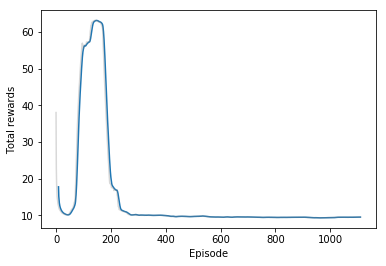

In [32]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

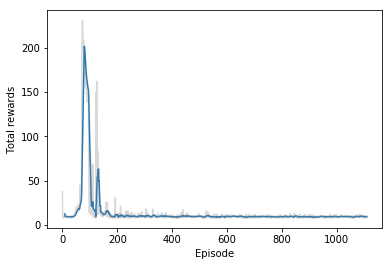

In [33]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

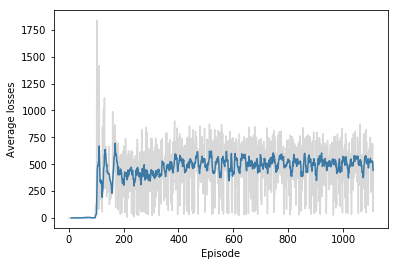

In [34]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episode/epoch
    for _ in range(10):
        total_reward = 0
        state = env.reset()
        initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
        
        # Steps/batches
        while True:
            env.render()
            action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                    feed_dict = {model.states: state.reshape([1, -1]), 
                                                                 model.initial_state: initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # At the end of each episode
        print('total_reward:{}'.format(total_reward))

# Close the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.